#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from datetime import date
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline

#### Load the data

In [2]:
listings = pd.read_csv('listings.csv')
calendar = pd.read_csv('calendar.csv')
reviews = pd.read_csv('reviews.csv')

In [41]:
warnings.simplefilter('ignore')

#### Business Understanding
1. What is the peak season in Seattle as determined by price and listing availability?
2. What factors correlate with listing price, as determined by a linear regression model?
3. Which neighborhoods in Seattle have the best reviews on average?

# Question 1: What is the peak Season in Seattle as determined by price and availability?

In [3]:
#check out the calendar data set
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


#### check for nulls

In [4]:
cols = calendar.columns.unique()
for i in cols:
    print(i, calendar[i].isnull().sum()/len(calendar))

listing_id 0.0
date 0.0
available 0.0
price 0.32938998399793334


#### 33% of price data is missing. Let's try dropping the NaNs.

#### Nope don't do that, dropping the NaNs shows only available listings

#### Need to convert price to an numeric, and drop the dollar sign

In [5]:
def fix_price(df, col):
    ''' 
    This function will remove the dollar sign, extra zeros, and commas from the listed column in the listed dataframe,
    and make the column numeric.
    '''
    df[col] = df[col].str.replace('$','').str.replace('.00','').str.replace(',','')
    df[col] = pd.to_numeric(df[col])
    return df

In [6]:
calendar = fix_price(calendar, 'price')

In [7]:
#check that it worked
calendar['price'].dtypes

dtype('float64')

#### Need to convert available from t/f to 1/0

In [8]:
calendar['available'].unique()

array(['t', 'f'], dtype=object)

In [9]:
conditions = [
        calendar['available'] == 't',
        calendar['available'] == 'f',
    ]
choices = [int(1), int(0)]
calendar['avail_true'] = np.select(conditions, choices, default = int(0))

#### Let's explore availability and price by time of year

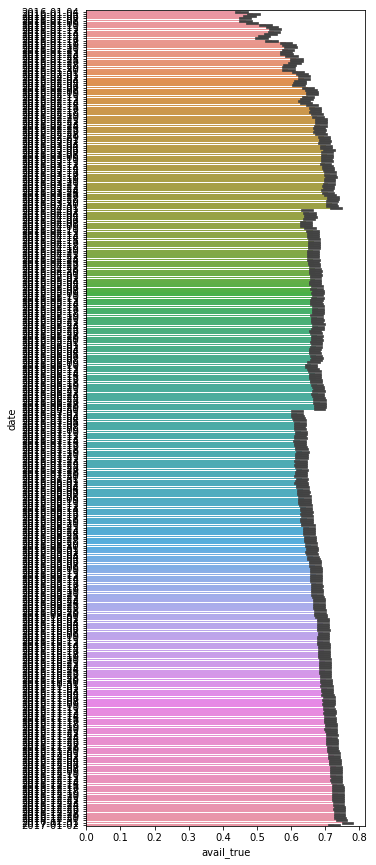

In [10]:
plt.figure(figsize=(5,15))
sns.barplot(x='avail_true', y='date', data = calendar);

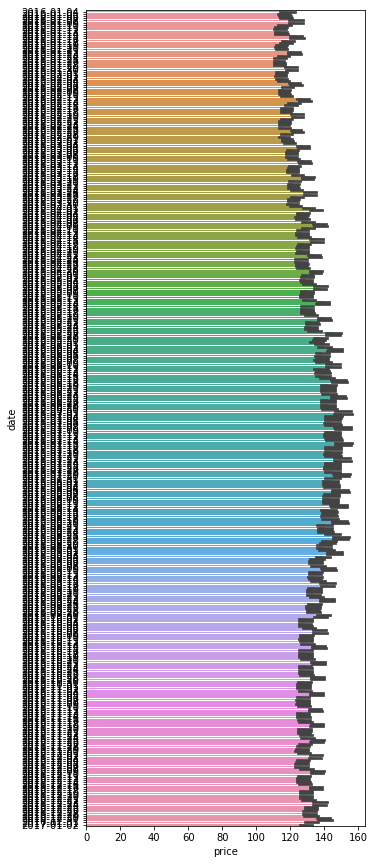

In [11]:
plt.figure(figsize=(5,15))
sns.barplot(x='price', y='date', data = calendar);

#### These graphs are not readable. Need to group by week or month

#### This needs to be done to work with date

In [12]:
def calendar_details(df):
    df['year'] = pd.DatetimeIndex(df['date']).year
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['day'] = pd.DatetimeIndex(df['date']).day
    return df

In [13]:
calendar = calendar_details(calendar)

Text(0, 0.5, 'Mean Proportion Available')

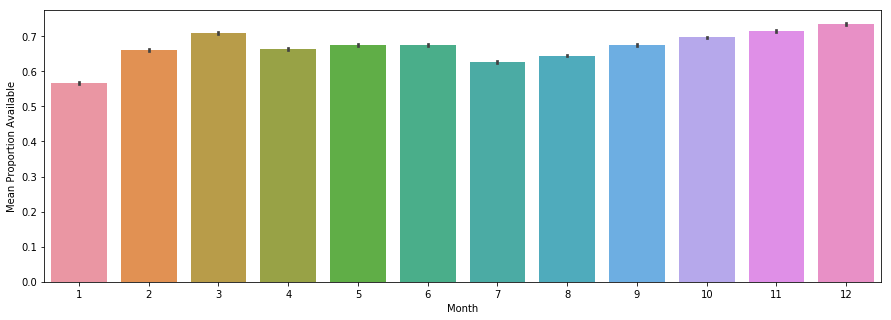

In [14]:
plt.figure(figsize=(15,5))
sns.barplot(x='month', y='avail_true', data = calendar);
plt.xlabel('Month')
plt.ylabel('Mean Proportion Available')

In [15]:
stats.f_oneway(calendar['avail_true'][calendar['month'] == 1], 
             calendar['avail_true'][calendar['month'] == 2],
             calendar['avail_true'][calendar['month'] == 3],
             calendar['avail_true'][calendar['month'] == 4],
             calendar['avail_true'][calendar['month'] == 5],
             calendar['avail_true'][calendar['month'] == 6],
             calendar['avail_true'][calendar['month'] == 7], 
             calendar['avail_true'][calendar['month'] == 8],
             calendar['avail_true'][calendar['month'] == 9],
             calendar['avail_true'][calendar['month'] == 10],
             calendar['avail_true'][calendar['month'] == 11], 
             calendar['avail_true'][calendar['month'] == 12])

F_onewayResult(statistic=1046.6810982919371, pvalue=0.0)

Text(0, 0.5, 'Mean Price')

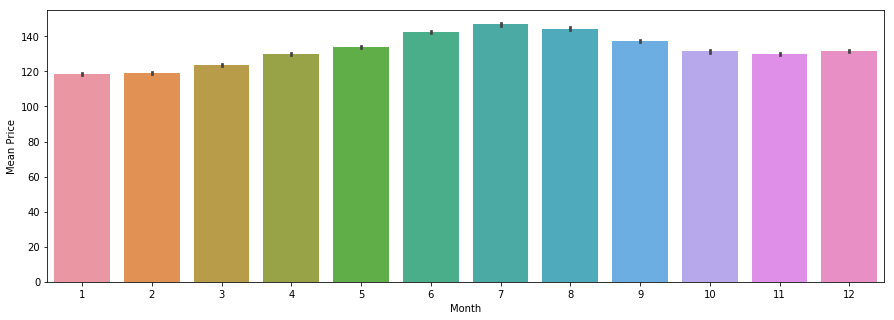

In [16]:
plt.figure(figsize=(15,5))
sns.barplot(x='month', y='price', data = calendar);
plt.xlabel('Month')
plt.ylabel('Mean Price')

In [17]:
stats.f_oneway(calendar['price'].dropna()[calendar['month'] == 1], 
             calendar['price'].dropna()[calendar['month'] == 2],
             calendar['price'].dropna()[calendar['month'] == 3],
             calendar['price'].dropna()[calendar['month'] == 4],
             calendar['price'].dropna()[calendar['month'] == 5],
             calendar['price'].dropna()[calendar['month'] == 6],
             calendar['price'].dropna()[calendar['month'] == 7], 
             calendar['price'].dropna()[calendar['month'] == 8],
             calendar['price'].dropna()[calendar['month'] == 9],
             calendar['price'].dropna()[calendar['month'] == 10],
             calendar['price'].dropna()[calendar['month'] == 11], 
             calendar['price'].dropna()[calendar['month'] == 12])

F_onewayResult(statistic=631.867651726935, pvalue=0.0)

#### Check on weekly prices just out of curiosity

In [24]:
calendar['datetime'] = pd.to_datetime(calendar['date'])
data1 = calendar.sort_values('datetime').set_index('datetime')
week_groups_resample = data1.resample('W').mean()
week_groups_std = data1.resample('W').std()

In [25]:
price_by_week = week_groups_resample.drop(['listing_id', 'year', 'month', 'day', 'avail_true'], axis=1)
price_std = week_groups_std.drop(['listing_id', 'year', 'month', 'day', 'avail_true'], axis=1)

In [26]:
x = np.arange(len(price_by_week))
x = x+1

Text(0, 0.5, '')

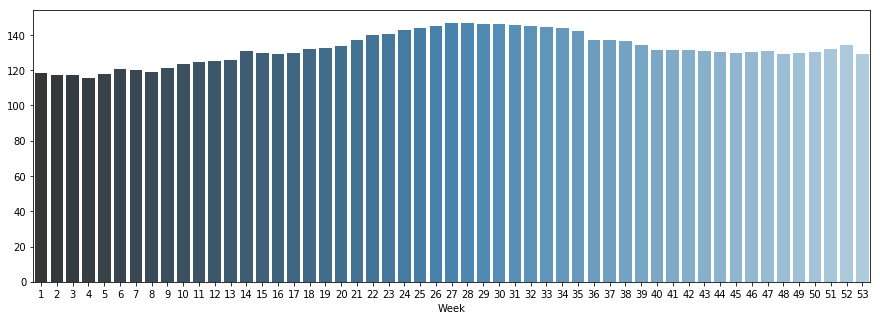

In [27]:
plt.figure(figsize=(15,5))             
sns.barplot(x, y=price_by_week['price'], palette="Blues_d")
plt.xlabel('Week')
plt.ylabel('')

# 2. What variables are predictive of price?

#### Take a first look at the listing info by using a heatmap

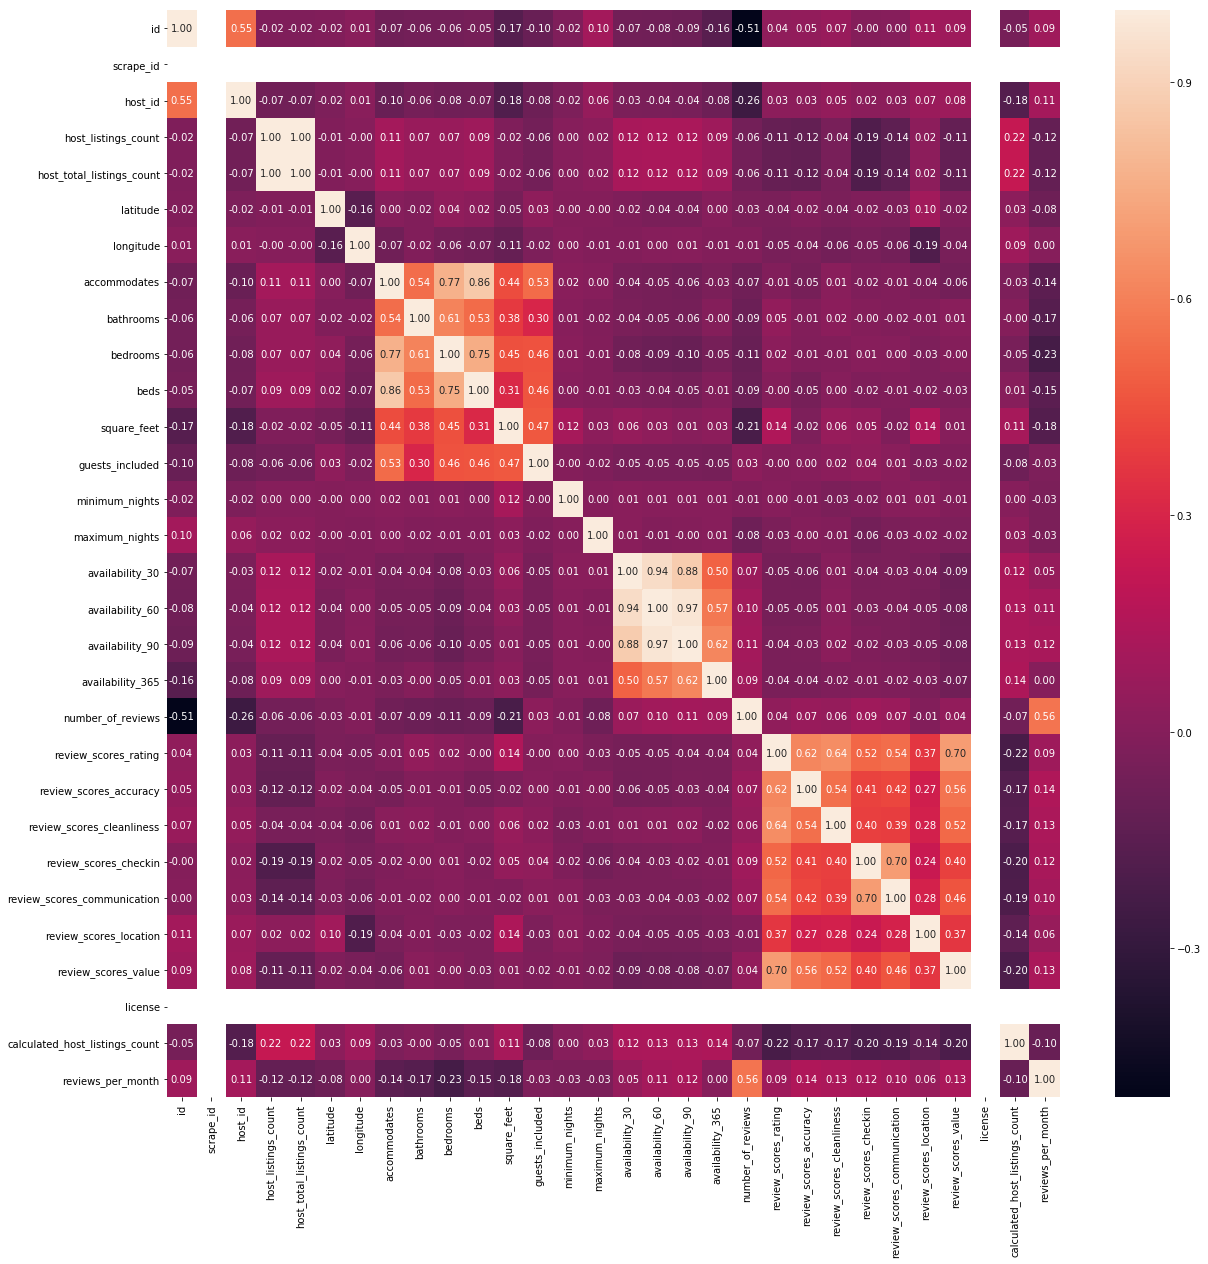

In [28]:
plt.figure(figsize=(20,20))
sns.heatmap(listings.corr(), annot=True, fmt=".2f");

In [29]:
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


### To answer question 2, need to merge calendar and listings

In [30]:
# Rename columns to prepare for merge
calendar = calendar.rename(columns = {'price':'calendar_price'})
listings = listings.rename(columns = {'id':'listing_id'})

In [31]:
lcdf = calendar.merge(listings, on=['listing_id'])

In [32]:
# Check number of NaNs in columns
lcdf.isna().sum().sort_values(ascending=False)

license             1393570
square_feet         1358165
monthly_price        839865
security_deposit     712480
weekly_price         660285
                     ...   
room_type                 0
accommodates              0
bed_type                  0
amenities                 0
listing_id                0
Length: 100, dtype: int64

In [33]:
len(lcdf)

1393570

In [34]:
#drop license and square_feet since they are all or mostly NaNs
lcdf = lcdf.drop(columns = ['license', 'square_feet'])

In [35]:
lcdf['calendar_price'].describe()

count    871431.000000
mean        132.483885
std          96.547901
min          10.000000
25%          75.000000
50%         109.000000
75%         154.000000
max        1650.000000
Name: calendar_price, dtype: float64

In [36]:
#check the column names to pick possible features for the model
lcdf.columns.values

array(['listing_id', 'date', 'available', 'calendar_price', 'avail_true',
       'year', 'month', 'day', 'datetime', 'listing_url', 'scrape_id',
       'last_scraped', 'name', 'summary', 'space', 'description',
       'experiences_offered', 'neighborhood_overview', 'notes', 'transit',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', '

In [37]:
#What amenities are possible to have?
lcdf['amenities'].unique()

array(['{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,Heating,"Family/Kid Friendly",Washer,Dryer}',
       '{TV,Internet,"Wireless Internet",Kitchen,"Free Parking on Premises","Buzzer/Wireless Intercom",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials}',
       '{TV,"Cable TV",Internet,"Wireless Internet","Air Conditioning",Kitchen,"Free Parking on Premises","Pets Allowed","Pets live on this property",Dog(s),Cat(s),"Hot Tub","Indoor Fireplace",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector",Essentials,Shampoo}',
       ...,
       '{"Cable TV","Wireless Internet",Kitchen,"Free Parking on Premises",Breakfast,"Pets live on this property",Dog(s),Cat(s),Heating,Washer,Dryer,"Smoke Detector","First Aid Kit","Safety Card","Fire Extinguisher",Essentials,Hangers,"Hair Dryer",Iron,"Laptop Friendly Workspace"}',
       '{TV,"Wireless I

In [38]:
#lets add some columns to tell us whether or not certain amenities are present
new_amenity_columns =['wireless_internet|Wireless Internet','heating|Heating','kitchen|Kitchen','smoke_detector|Smoke Detector','dryer|Dryer','washer|Washer','internet|Internet','hot_tub|Hot Tub','tv|TV',
                        'free_parking|Free Parking', 'kids|Family/Kid Friendly']

for c in new_amenity_columns:
    amenity_column,words = c.split('|')
    lcdf[amenity_column] = lcdf['amenities'].apply(lambda x: 1 if words in x else 0)

In [39]:
#make sure the amenity thing worked
lcdf.columns.values

array(['listing_id', 'date', 'available', 'calendar_price', 'avail_true',
       'year', 'month', 'day', 'datetime', 'listing_url', 'scrape_id',
       'last_scraped', 'name', 'summary', 'space', 'description',
       'experiences_offered', 'neighborhood_overview', 'notes', 'transit',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', '

In [40]:
#make date useful to this model
lcdf['date'] = [pd.datetime.strptime(x, '%Y-%m-%d') for x in lcdf['date']]
lcdf['date'] = pd.to_datetime(lcdf['date'],format='%y-%m-%d')
lcdf['numerical_day'] = lcdf['date'].dt.dayofyear
lcdf['numerical_day']#number from 1 to 365 corresponding to the day of the year

/home/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


0            4
1            5
2            6
3            7
4            8
          ... 
1393565    364
1393566    365
1393567    366
1393568      1
1393569      2
Name: numerical_day, Length: 1393570, dtype: int64

#### Let's give modeling a try

In [1]:
#Use the function learned in class, but update it to include relevant features to set up the model. 
def prep_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    '''
    # Drop rows with missing salary values
    df = df.dropna(subset=['calendar_price'], axis=0)
    y = df['calendar_price']
    
    #Drop rows with missing rating values
  
    
    #choose columns to include in model
    features = df[['numerical_day', 'beds', 'bedrooms', 'bathrooms', 'neighbourhood_cleansed', 
                  'review_scores_rating', 'zipcode', 'latitude', 'longitude','property_type',
                  'bed_type', 'wireless_internet', 'heating',
                  'kitchen', 'smoke_detector', 'dryer', 'washer', 'internet',
                  'hot_tub', 'tv', 'free_parking', 'kids']]
    
    # Fill numeric columns with the mean
    num_vars = features.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        features[col].fillna((features[col].median()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = features.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        features = pd.concat([features.drop(var, axis=1), pd.get_dummies(features[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = features
    return X, y
    
#Use the function to create X and y
X, y = prep_data(lcdf)    

NameError: name 'lcdf' is not defined

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
#Instantiate
lm_model = LinearRegression(normalize=True) 

#Fit - why does this break?
lm_model.fit(X_train, y_train) 

#Predict
y_test_preds = lm_model.predict(X_test) 
#Score
"The r-squared score for your model was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))


'The r-squared score for your model was 0.5858546690516006 on 261430 values.'

# these models are kind of silly because include host name
features = df[['numerical_day', 'beds', 'bedrooms', 'bathrooms', 'neighbourhood_cleansed', 'host_response_time',
                  'review_scores_rating', 'host_name']]
    0.73

features = df[['numerical_day', 'beds', 'bedrooms', 'bathrooms', 'neighbourhood_cleansed', 'host_response_time',
                  'review_scores_rating', 'host_name', 'cancellation_policy']]
    0.735

features = df[['numerical_day', 'beds', 'bedrooms', 'bathrooms', 'neighbourhood_cleansed', 'host_response_time',
                  'review_scores_rating', 'host_name', 'zipcode', 'latitude', 'longitude']]
    0.736

features = df[['numerical_day', 'beds', 'bedrooms', 'bathrooms', 'neighbourhood_cleansed', 'host_response_time',
                  'review_scores_rating', 'host_name', 'zipcode', 'latitude', 'longitude', 
                   'calculated_host_listings_count']]
    0.737

features = df[['numerical_day', 'beds', 'bedrooms', 'bathrooms', 'neighbourhood_cleansed', 'host_response_time',
                  'review_scores_rating', 'zipcode', 'latitude', 'longitude', 
                   'calculated_host_listings_count', 'host_since']]
    0.77

features = df[['numerical_day', 'beds', 'bedrooms', 'bathrooms', 'neighbourhood_cleansed', 
                  'review_scores_rating', 'zipcode', 'latitude', 'longitude','month', 'property_type',
                  'bed_type', 'wireless_internet', 'heating',
                  'kitchen', 'smoke_detector', 'dryer', 'washer', 'internet',
                  'hot_tub', 'tv', 'free_parking', 'kids', 'host_name']]
    0.75

# these models are more logical
features = df[['numerical_day', 'beds', 'bedrooms', 'bathrooms', 'neighbourhood_cleansed', 
                  'review_scores_rating', 'zipcode', 'latitude', 'longitude', 
                   'calculated_host_listings_count', 'host_is_superhost', 'month', 'property_type',
                  'bed_type']]
0.58

features = df[['numerical_day', 'beds', 'bedrooms', 'bathrooms', 'neighbourhood_cleansed', 
                  'review_scores_rating', 'zipcode', 'latitude', 'longitude','month', 'property_type',
                  'bed_type']]0.58
features = df[['numerical_day', 'beds', 'bedrooms', 'bathrooms', 'neighbourhood_cleansed', 
                  'review_scores_rating', 'zipcode', 'latitude', 'longitude','property_type',
                  'bed_type', 'wireless_internet', 'heating',
                  'kitchen', 'smoke_detector', 'dryer', 'washer', 'internet',
                  'hot_tub', 'tv', 'free_parking', 'kids']]0.59

### Check the weights of features in my favorite model

In [43]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
5,latitude,-480.219915,480.219915
138,property_type_Dorm,-283.557986,283.557986
6,longitude,-225.720269,225.720269
132,property_type_Boat,131.348160,131.348160
87,neighbourhood_cleansed_South Delridge,-90.351141,90.351141
75,neighbourhood_cleansed_Pike-Market,68.492421,68.492421
50,neighbourhood_cleansed_Interbay,-65.134949,65.134949
72,neighbourhood_cleansed_North Queen Anne,-63.742443,63.742443
19,neighbourhood_cleansed_Arbor Heights,-63.585144,63.585144
124,zipcode_98136,-63.187283,63.187283


In [44]:
#Why do boats matter?
lcdf[lcdf['property_type']=='Boat']['calendar_price'].describe()

count    2275.000000
mean      330.618901
std       269.955170
min        75.000000
25%       150.000000
50%       150.000000
75%       680.000000
max       775.000000
Name: calendar_price, dtype: float64

In [45]:
#Why do dorms matter?
lcdf[lcdf['property_type']=='Dorm']['calendar_price'].describe()

count    426.000000
mean      39.384977
std        2.198857
min       38.000000
25%       38.000000
50%       38.000000
75%       40.000000
max       47.000000
Name: calendar_price, dtype: float64

In [57]:
#Compare boats and dorms to other property types
prop_type = pd.DataFrame(lcdf.groupby('property_type')['calendar_price'].mean().sort_values())
prop_type

,calendar_price
property_type,
Dorm,39.384977
Treehouse,50.825163
Tent,57.540046
Chalet,93.509009
Other,104.941254
Cabin,110.198464
Bed & Breakfast,116.048976
Yurt,120.000000
Bungalow,124.941213


#### Make a dataframe to look at listing price by location more easily

In [58]:
locs = pd.DataFrame(lcdf.groupby('listing_id')['latitude', 'longitude', 'calendar_price'].mean())
locs

/home/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,latitude,longitude,calendar_price
listing_id,,,
3335,47.529846,-122.275840,120.000000
4291,47.687251,-122.313130,82.000000
5682,47.523980,-122.359891,53.944984
6606,47.654109,-122.337605,90.000000
7369,47.615397,-122.325640,85.000000
...,...,...,...
10332096,47.730604,-122.297165,40.000000
10334184,47.626500,-122.319851,120.000000
10339144,47.619269,-122.313172,NaN


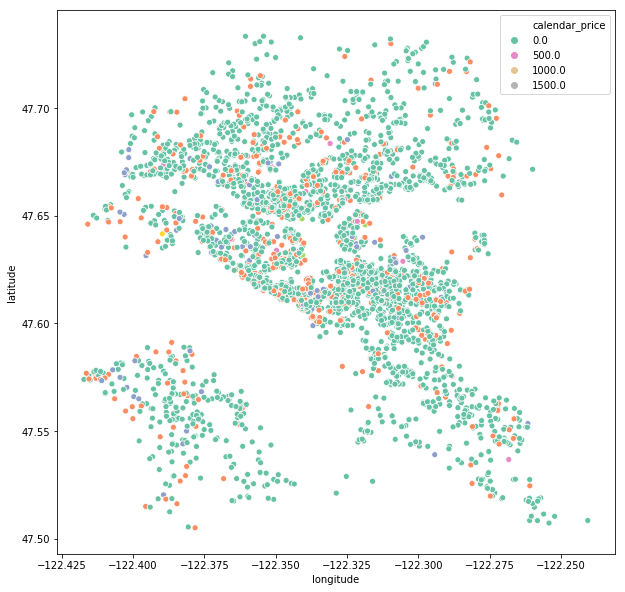

In [59]:
plt.figure(figsize=(10,10))
sns.scatterplot('longitude', 'latitude', data = locs, hue='calendar_price', palette = 'Set2')

In [60]:
#the above would be cooler overlaid on a map, let's get some coordinates to make a map
print(locs['latitude'].min())
print(locs['latitude'].max())
print(locs['longitude'].min())
print(locs['longitude'].max())

47.50508834369023
47.733357908564685
-122.41721881425538
-122.24060703053945


In [63]:
#Import the map I cropped using the above coordinates
seattle_map = plt.imread('seattlemap.png')

In [64]:
BBox = ((locs.longitude.min(),   locs.longitude.max(),      
         locs.latitude.min(), locs.latitude.max()))

In [65]:
#Overview of calendar_price to create bins used below
locs['calendar_price'].describe()

count    3554.000000
mean      132.317812
std        90.730918
min        10.000000
25%        75.000000
50%       110.000000
75%       157.549188
max      1312.903226
Name: calendar_price, dtype: float64

In [66]:
def price_binning(val):
    if val < 50:
        return '<$50'
    if 50 <= val < 100:
        return '$50-100'
    if 100 <= val < 150:
        return '$100-150'
    if 150 <= val < 200:
        return '$150-200'
    if val >= 200:
        return '$200+'
    
price_to_bin = locs['calendar_price']
locs['price_bin'] = price_to_bin.apply(price_binning)

Text(0, 0.5, 'Latitude')

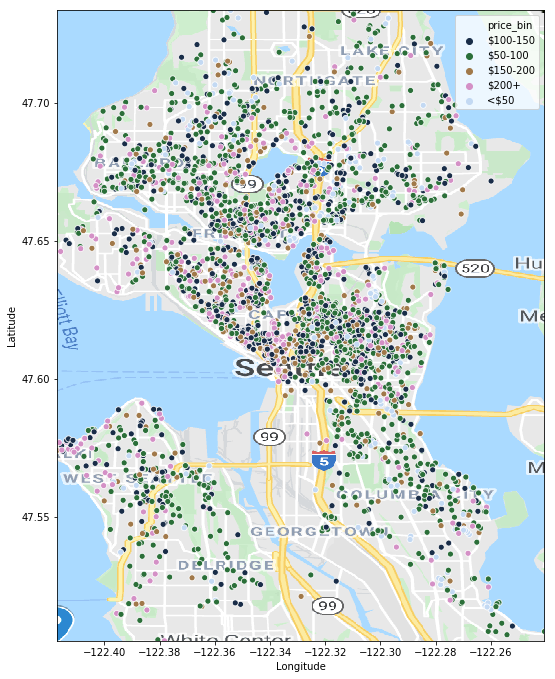

In [67]:
fig, ax = plt.subplots(figsize = (15,11.595))
sns.scatterplot(locs.longitude, locs.latitude, hue = locs['price_bin'], 
                palette='cubehelix')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(seattle_map, zorder=0,extent = BBox)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Question 3: Which neighborhoods in Seattle have the best reviews on average?

In [68]:
reviews.columns.values
#it looks like the review data I'm interested in is present in the listings df, so this is not needed

array(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name',
       'comments'], dtype=object)

In [69]:
listings.columns.values

array(['listing_id', 'listing_url', 'scrape_id', 'last_scraped', 'name',
       'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',

In [70]:
rev_group = pd.DataFrame(listings.groupby('neighbourhood_cleansed')['number_of_reviews',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'latitude', 'longitude', 'price'].mean())

/home/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [71]:
rev_group

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,latitude,longitude
neighbourhood_cleansed,,,,,,,,,,
Adams,27.828571,95.350877,9.666667,9.719298,9.912281,9.964912,9.877193,9.508772,47.671506,-122.386485
Alki,13.119048,95.892857,9.678571,9.750000,9.892857,9.857143,9.892857,9.500000,47.575052,-122.408047
Arbor Heights,9.200000,98.000000,9.666667,9.666667,10.000000,10.000000,8.666667,9.333333,47.510429,-122.381931
Atlantic,22.000000,95.333333,9.690476,9.666667,9.809524,9.738095,9.095238,9.571429,47.595164,-122.305620
Belltown,20.025641,93.477833,9.477833,9.561576,9.581281,9.694581,9.817734,9.197044,47.615147,-122.345487
...,...,...,...,...,...,...,...,...,...,...
West Woodland,33.937500,95.166667,9.740741,9.518519,9.851852,9.925926,9.648148,9.481481,47.669077,-122.366817
Westlake,4.764706,96.500000,9.600000,9.200000,9.700000,9.700000,9.600000,9.400000,47.631958,-122.341871
Whittier Heights,50.307692,96.666667,9.750000,9.916667,10.000000,9.958333,9.791667,9.750000,47.682390,-122.371655


#### Look at which neighborhoods got the best reviews in categories of interest

In [72]:
rev_group.nlargest(6, ['review_scores_location']) 

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,latitude,longitude
neighbourhood_cleansed,,,,,,,,,,
Pike-Market,18.178571,92.652174,9.695652,9.478261,9.478261,9.565217,9.913043,9.217391,47.609089,-122.340757
Alki,13.119048,95.892857,9.678571,9.750000,9.892857,9.857143,9.892857,9.500000,47.575052,-122.408047
Fauntleroy,34.400000,96.111111,9.777778,9.888889,9.888889,9.777778,9.888889,10.000000,47.521486,-122.389487
Laurelhurst,15.800000,96.777778,10.000000,10.000000,10.000000,10.000000,9.888889,9.777778,47.662083,-122.279564
Adams,27.828571,95.350877,9.666667,9.719298,9.912281,9.964912,9.877193,9.508772,47.671506,-122.386485
Lower Queen Anne,21.808511,95.178082,9.835616,9.561644,9.890411,9.931507,9.876712,9.643836,47.624798,-122.355500


In [73]:
rev_group.nlargest(6, ['review_scores_rating']) 

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,latitude,longitude
neighbourhood_cleansed,,,,,,,,,,
Arbor Heights,9.200000,98.000000,9.666667,9.666667,10.000000,10.000000,8.666667,9.333333,47.510429,-122.381931
Riverview,48.625000,97.250000,9.875000,10.000000,10.000000,10.000000,9.125000,9.625000,47.544510,-122.356837
Southeast Magnolia,16.529412,97.214286,9.857143,9.714286,9.928571,9.928571,9.785714,9.714286,47.643545,-122.388246
Madrona,15.319149,97.100000,9.800000,9.750000,9.875000,9.900000,9.775000,9.794872,47.613445,-122.290689
Harrison/Denny-Blaine,54.500000,97.083333,9.833333,9.750000,10.000000,10.000000,9.666667,9.750000,47.622580,-122.291475
Genesee,9.529412,96.933333,9.866667,9.833333,9.966667,9.933333,9.866667,9.833333,47.564946,-122.385798


In [74]:
rev_group.nlargest(6, ['review_scores_value']) 

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,latitude,longitude
neighbourhood_cleansed,,,,,,,,,,
Fauntleroy,34.400000,96.111111,9.777778,9.888889,9.888889,9.777778,9.888889,10.000000,47.521486,-122.389487
Genesee,9.529412,96.933333,9.866667,9.833333,9.966667,9.933333,9.866667,9.833333,47.564946,-122.385798
Gatewood,22.045455,95.500000,9.750000,9.687500,10.000000,9.937500,9.750000,9.812500,47.539181,-122.385053
Maple Leaf,20.166667,95.277778,9.805556,9.638889,9.861111,9.916667,9.416667,9.805556,47.698632,-122.316529
Rainier Beach,20.666667,95.133333,9.466667,9.666667,9.666667,9.866667,8.933333,9.800000,47.513951,-122.258468
Madrona,15.319149,97.100000,9.800000,9.750000,9.875000,9.900000,9.775000,9.794872,47.613445,-122.290689


In [75]:
rev_group.nlargest(6, ['review_scores_accuracy']) 

,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,latitude,longitude
neighbourhood_cleansed,,,,,,,,,,
Laurelhurst,15.800000,96.777778,10.000000,10.000000,10.000000,10.000000,9.888889,9.777778,47.662083,-122.279564
Meadowbrook,16.333333,96.142857,10.000000,9.857143,10.000000,10.000000,9.428571,9.714286,47.706630,-122.295389
Roxhill,3.500000,93.000000,10.000000,9.500000,10.000000,10.000000,9.500000,9.500000,47.528036,-122.372297
North Delridge,19.281250,96.600000,9.880000,9.600000,10.000000,9.960000,9.520000,9.720000,47.562673,-122.365520
Riverview,48.625000,97.250000,9.875000,10.000000,10.000000,10.000000,9.125000,9.625000,47.544510,-122.356837
Genesee,9.529412,96.933333,9.866667,9.833333,9.966667,9.933333,9.866667,9.833333,47.564946,-122.385798


#### Pike Market seems to have the best ratings for location, whereas Fauntleroy is best for value and overall rating. 

A. Look at distributions to see how variable reviews are.

B. Can we plot the data to see where the best reviewed neighborhoods are?

#### 1. Look at distributions of review scores by neighborhood. 

#### Start with location

In [77]:
listings['review_scores_location'].describe()

count    3163.000000
mean        9.608916
std         0.629053
min         4.000000
25%         9.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: review_scores_location, dtype: float64

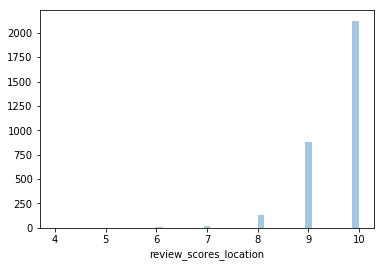

In [79]:
#first let's just look at location reviews overall
sns.distplot(listings['review_scores_location'].dropna(), kde=False)

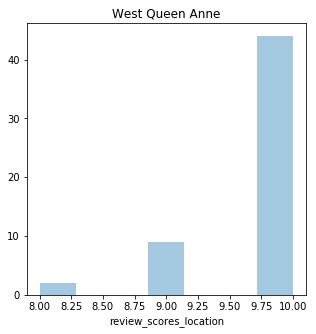

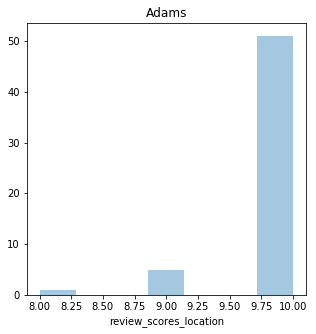

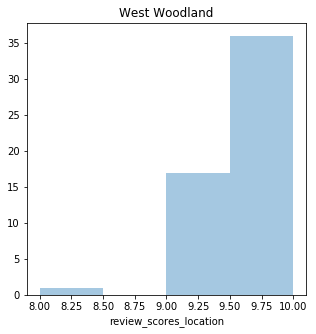

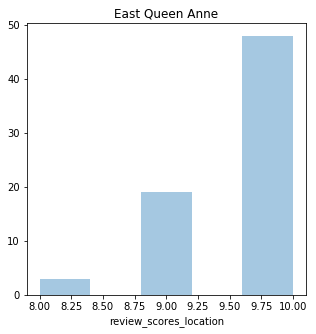

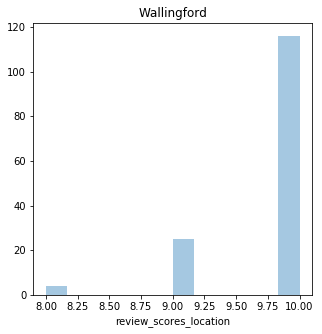

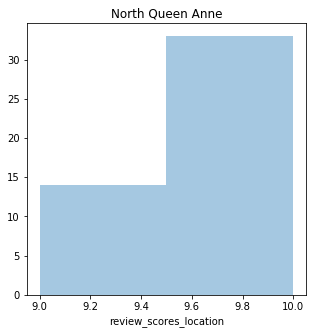

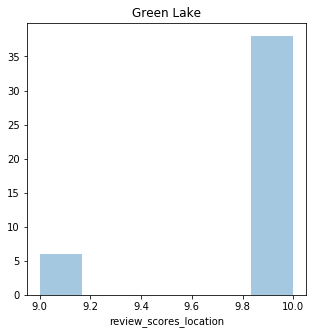

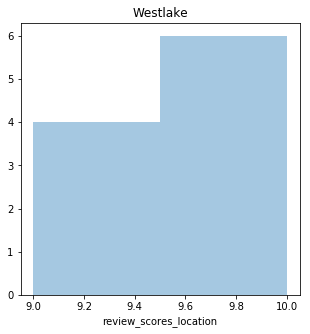

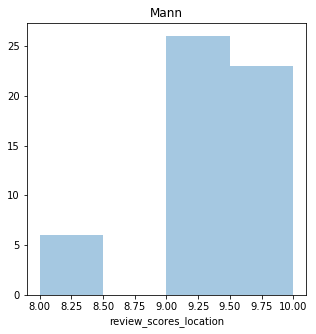

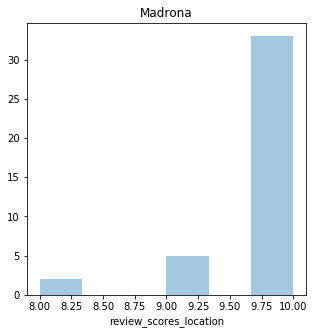

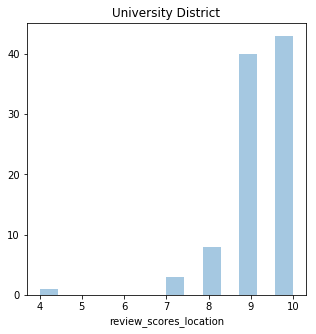

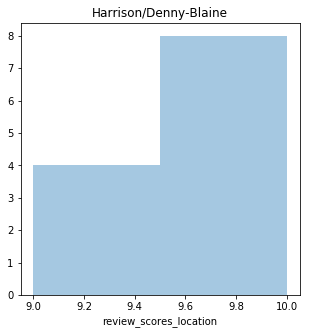

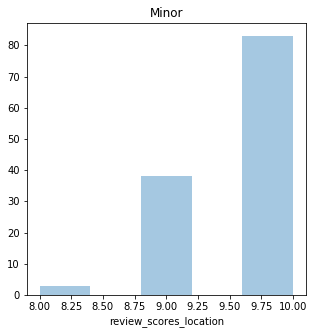

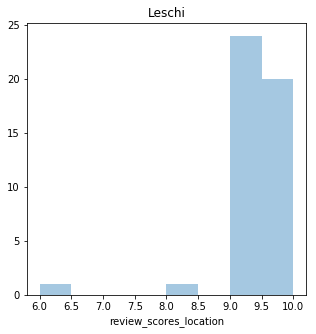

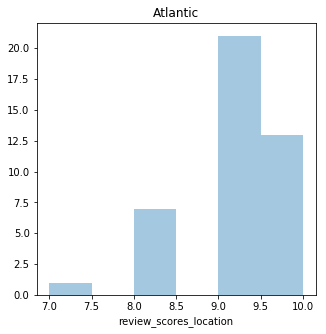

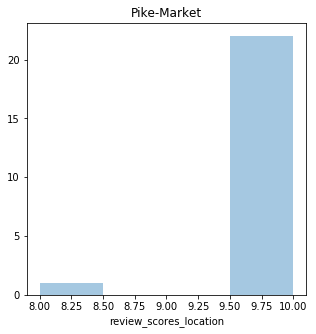

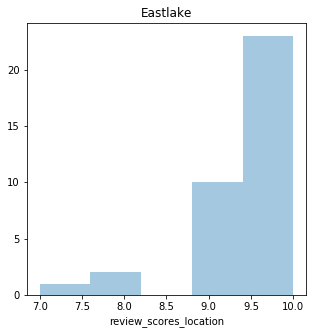

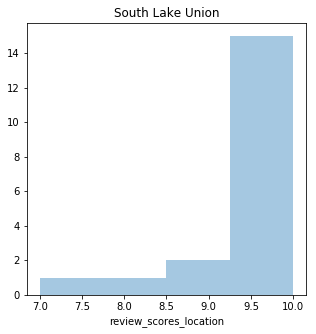

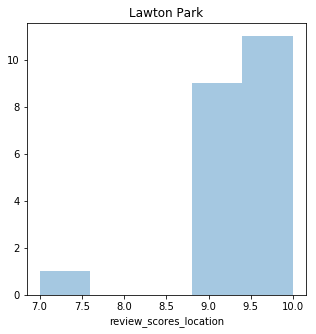

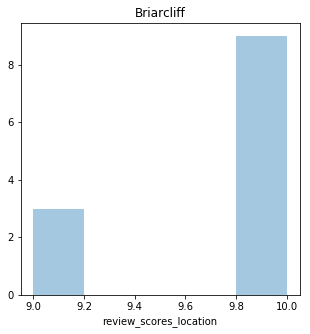

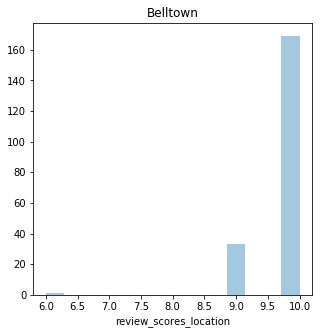

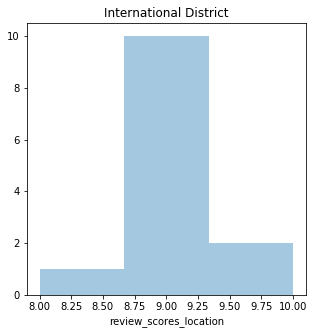

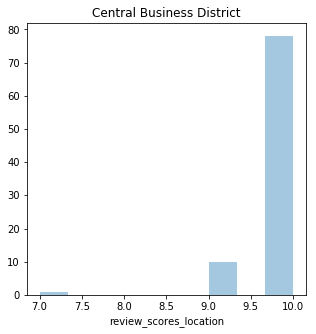

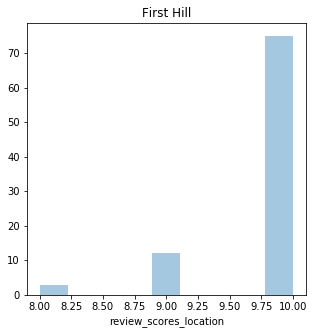

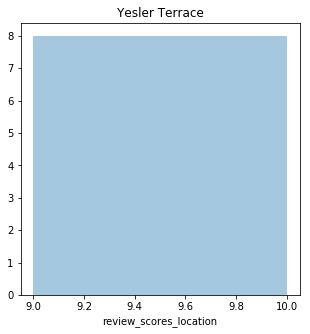

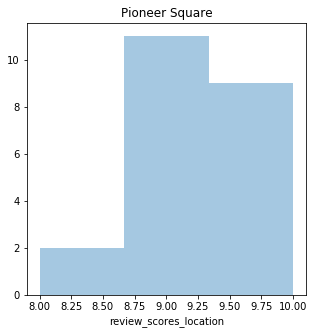

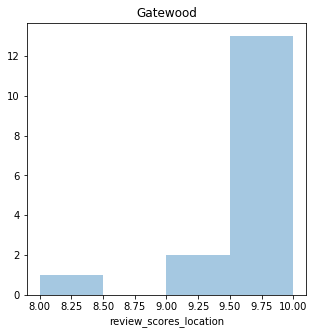

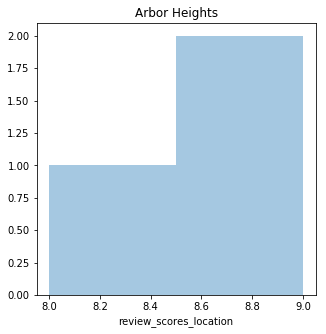

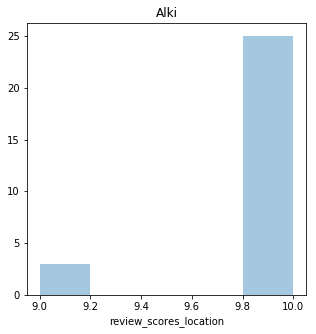

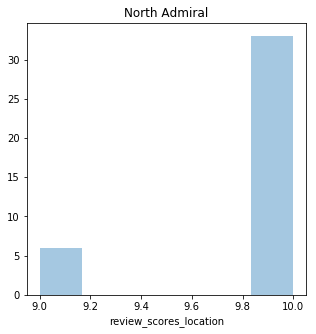

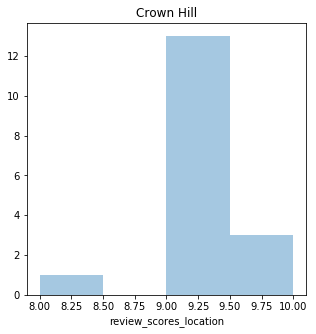

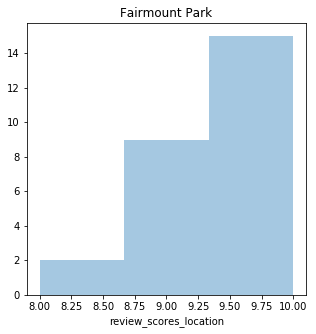

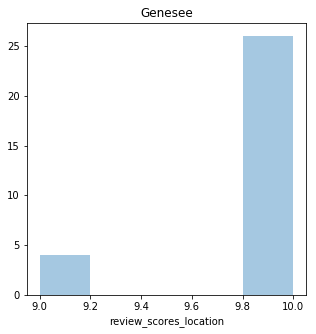

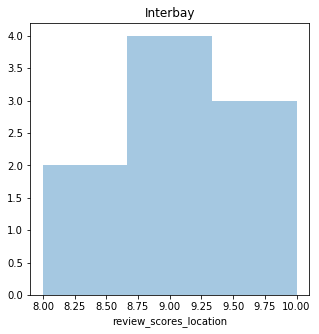

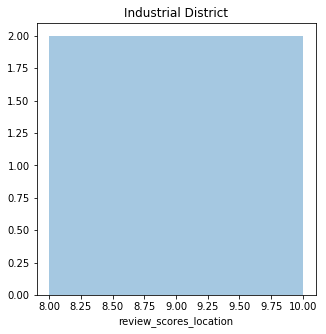

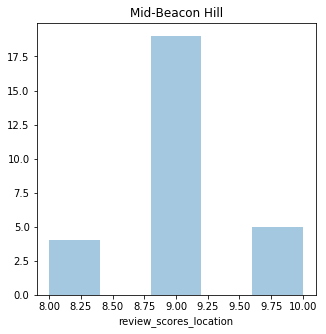

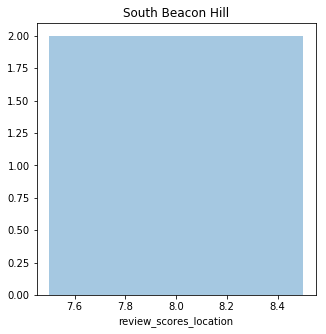

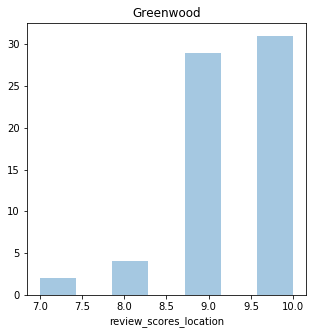

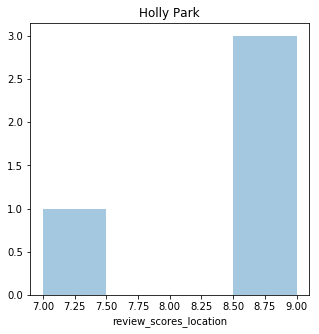

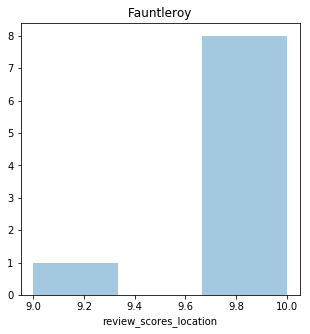

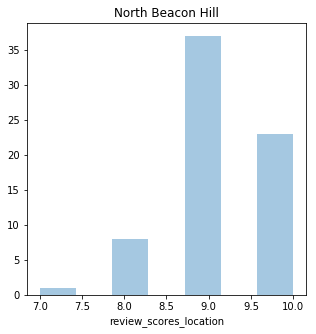

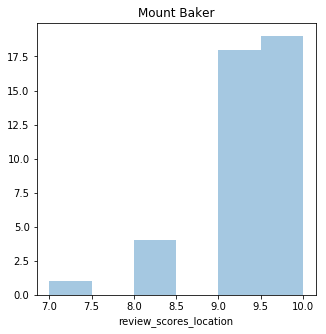

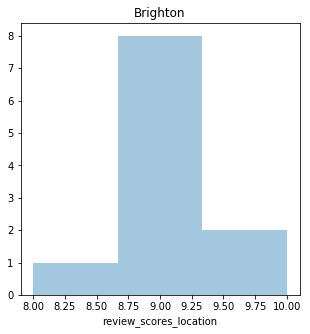

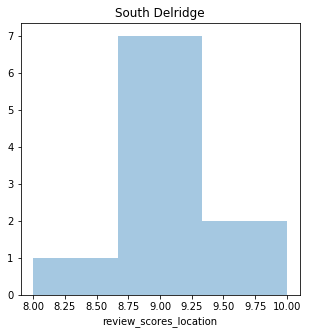

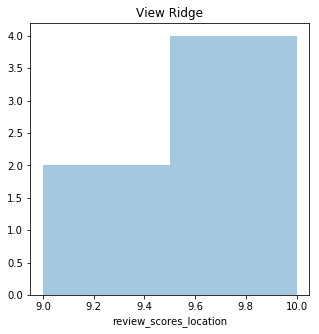

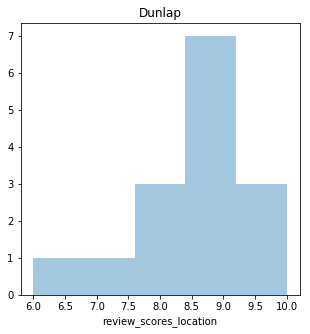

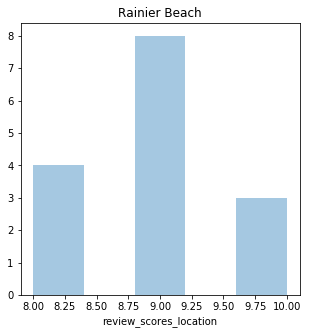

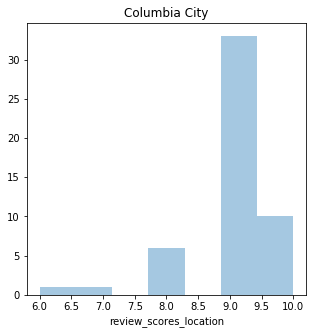

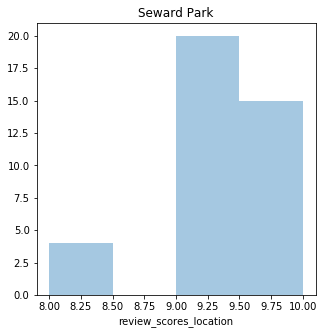

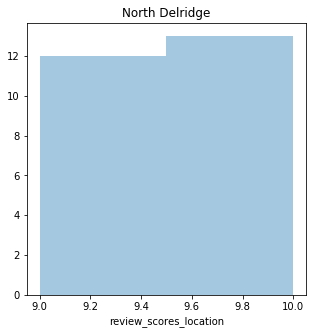

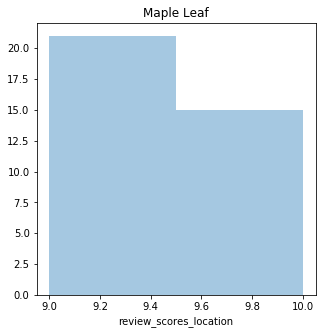

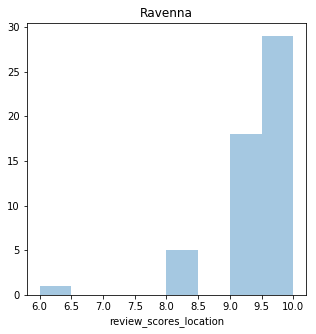

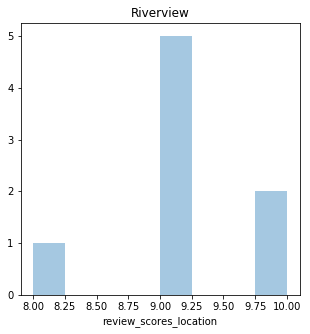

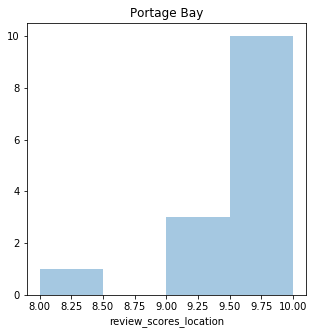

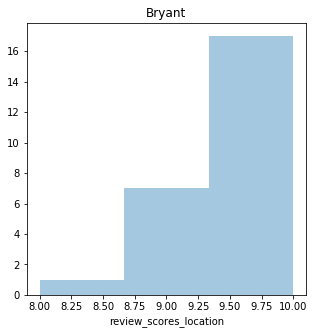

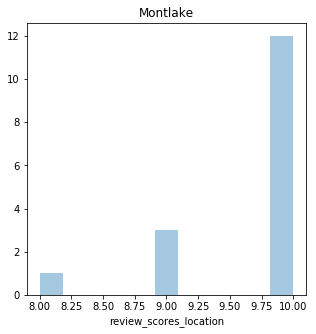

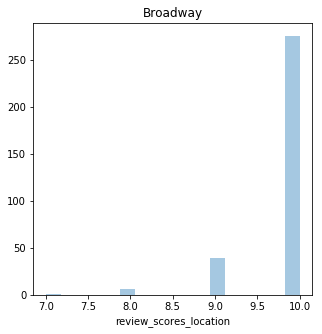

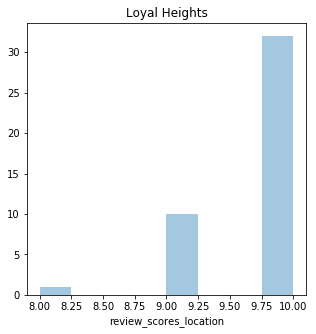

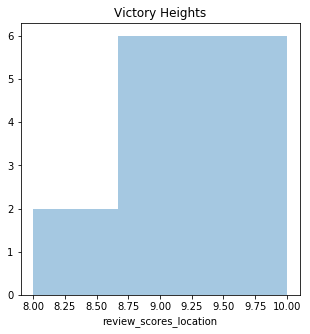

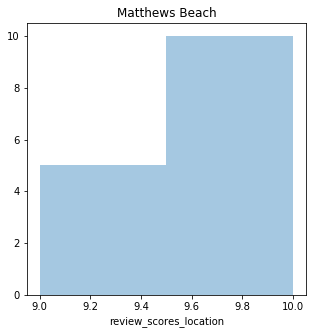

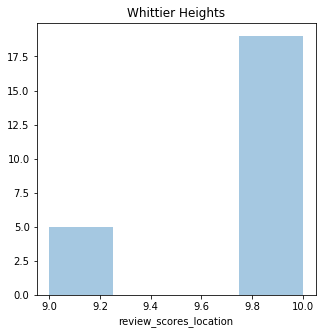

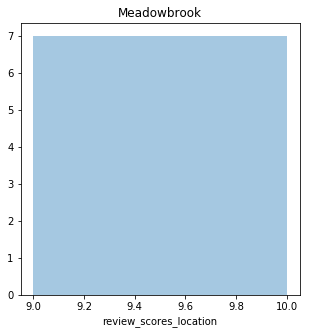

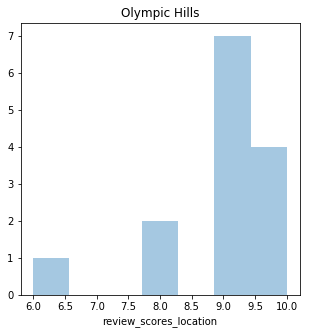

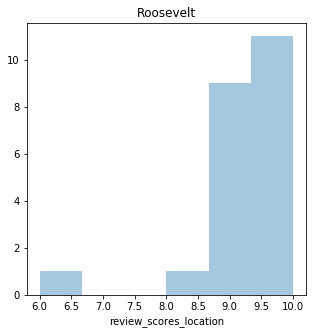

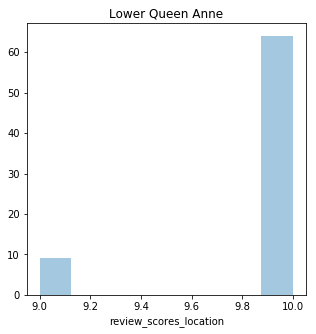

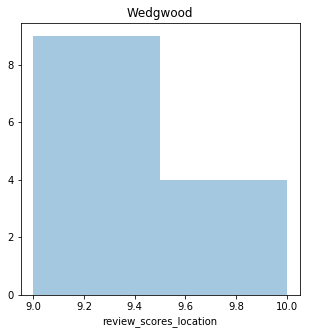

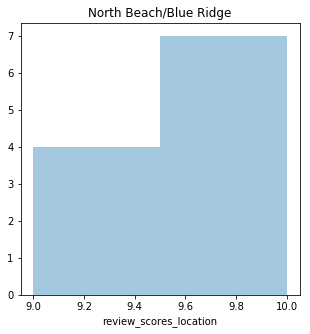

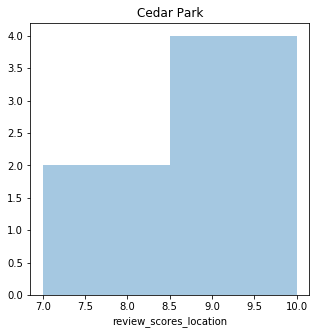

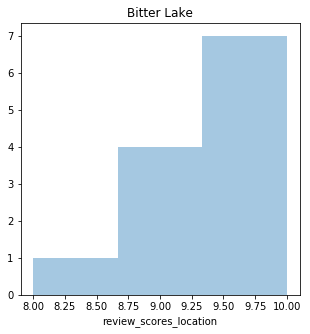

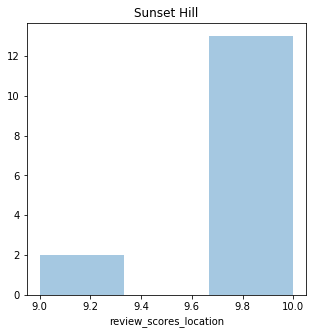

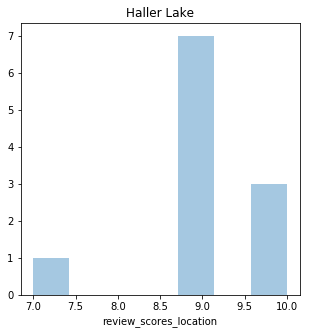

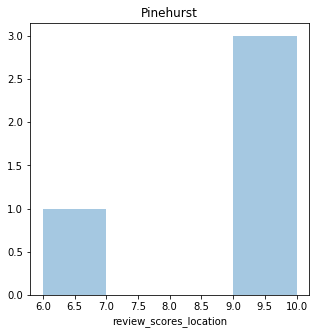

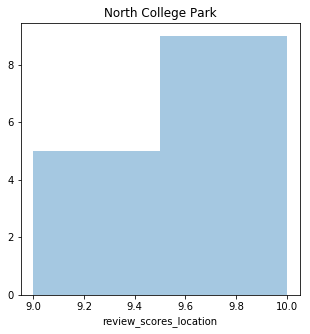

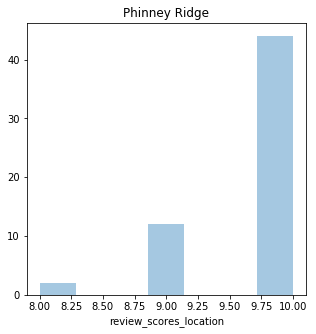

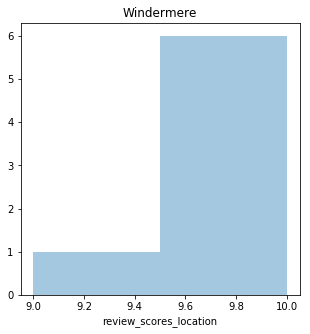

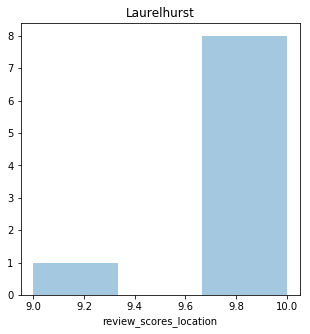

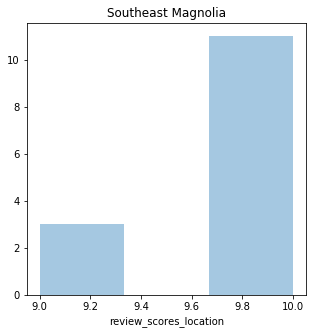

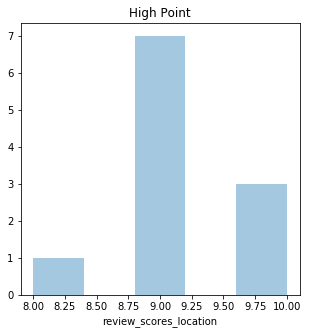

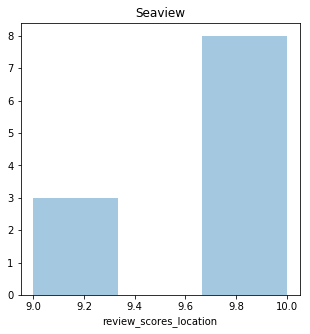

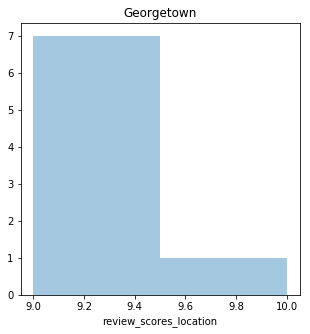

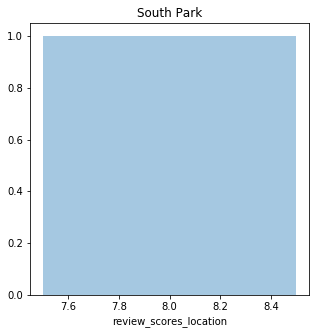

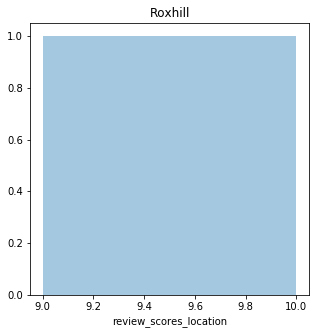

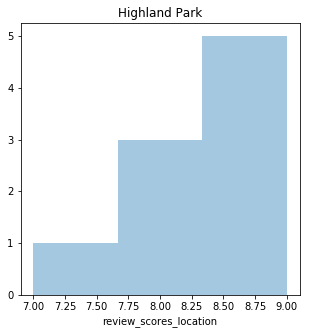

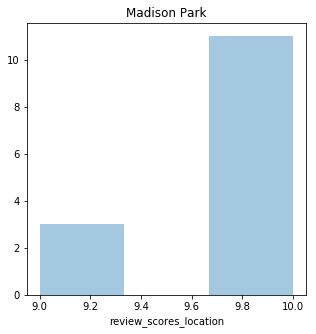

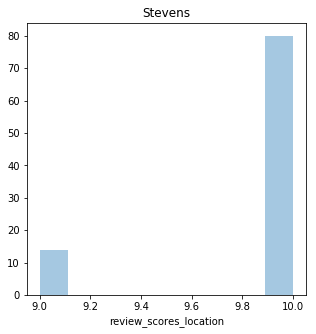

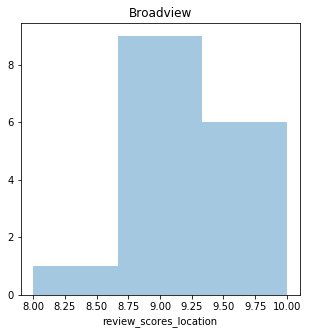

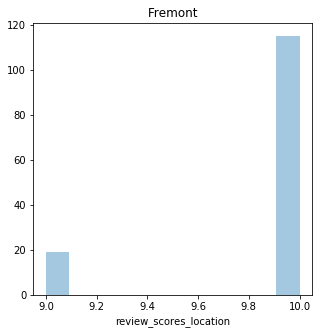

In [81]:
for i in listings['neighbourhood_cleansed'].unique():
    cur_df = listings[listings['neighbourhood_cleansed'] == i]
    fig, ax = plt.subplots(figsize = (5,5))
    sns.distplot(cur_df['review_scores_location'].dropna(), kde=False)
    plt.title(i)
    plt.show()

In [83]:
listings['review_scores_rating'].describe()

count    3171.000000
mean       94.539262
std         6.606083
min        20.000000
25%        93.000000
50%        96.000000
75%        99.000000
max       100.000000
Name: review_scores_rating, dtype: float64

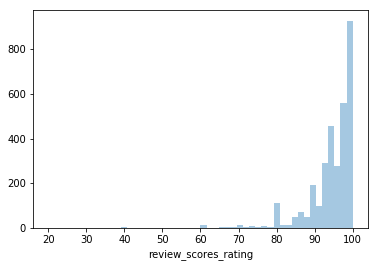

In [85]:
#next let's just look at overall ratings
sns.distplot(listings['review_scores_rating'].dropna(), kde=False)

#### 2. Plot to see where the best reviewed neighborhoods are.

In [90]:
def review_binning(val):
    if val < 8.5:
        return 'fair'
    if 8.5 <= val < 9:
        return 'good'
    if 9 <= val < 9.5:
        return 'great'
    if 9.5 <= val < 10:
        return 'excellent'
    if val == 10:
        return 'perfect'
    
review_to_bin = rev_group['review_scores_location']
rev_group['review_bin'] = review_to_bin.apply(review_binning)

Text(0, 0.5, 'Latitude')

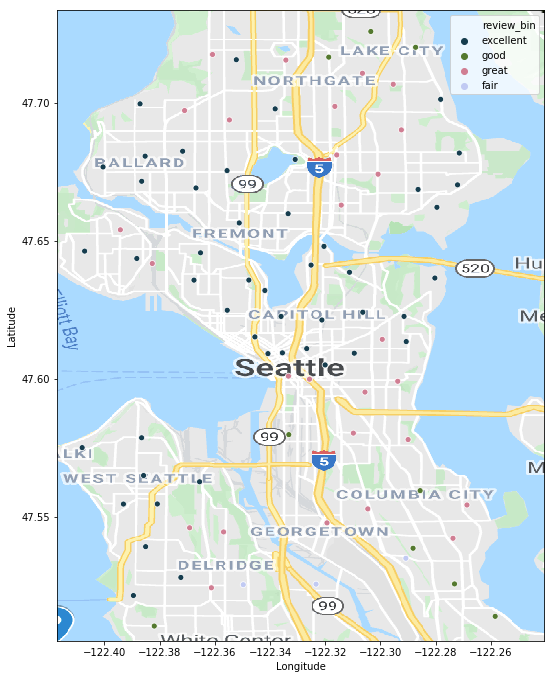

In [91]:
fig, ax = plt.subplots(figsize = (15,11.595))
sns.scatterplot(rev_group.longitude, rev_group.latitude, hue = rev_group['review_bin'], 
                palette='cubehelix')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(seattle_map, zorder=0,extent = BBox)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [93]:
revdf = fix_price(listings, 'price')

In [94]:
clean_revdf = revdf.dropna(subset=['price', 'review_scores_location', 'review_scores_rating'], axis=0)

In [95]:
r,p = stats.pearsonr(clean_revdf['price'], clean_revdf['review_scores_location'])

In [96]:
print(r,p)

0.10014510636787192 4.9146663033752276e-08


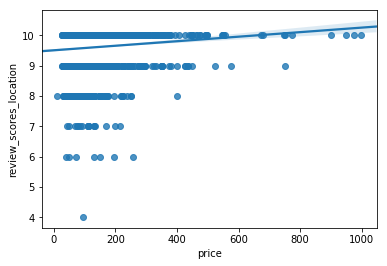

In [97]:
sns.regplot('price', 'review_scores_location', data = clean_revdf)

In [98]:
r2,p2 = stats.pearsonr(clean_revdf['price'], clean_revdf['review_scores_rating'])

In [99]:
print(r2,p2)

0.06005280653079571 0.0010927921126306953


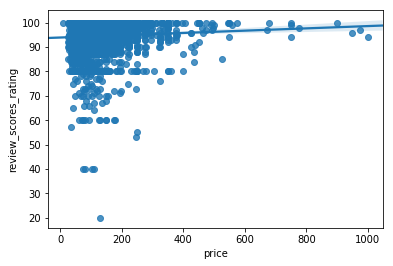

In [100]:
sns.regplot('price', 'review_scores_rating', data = clean_revdf)